# Undisclosed Window Washing Company: Data Analysis

This notebook was built to identify which clients were most likely to upsell to prescription packages with a window cleaning company in Chicago.

The outline for this notebook is as follows:
> I. [Loading Data](#section-1) <br /> 
> II. [Preliminary Analysis](#section-2) <br /> 
> III. [Modeling](#section-3) <br /> 

<a id='section-1'></a>
## I. Loading Data

In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point, Polygon

pd.set_option('display.max_columns', None)

In [11]:
# Path for datasets
path = 'Datasets_09.06.2019/'

# Loading data and removing extra rows
invoices = pd.read_csv(path+'Invoices Report.csv', 
                          skiprows=13, 
                          skipfooter=1, 
                          engine='python')
one_off = pd.read_csv(path+'One off Jobs Report.csv', 
                          skiprows=11, 
                          skipfooter=1, 
                          engine='python')
payments = pd.read_csv(path+'Jobber Payments Transaction List.csv', 
                          skiprows=0, 
                          skipfooter=1, 
                          engine='python')
properties = pd.read_csv(path+'Client Properties.csv', 
                          skiprows=0, 
                          skipfooter=1, 
                          engine='python')
recurring = pd.read_csv(path+'Recurring Jobs Report.csv', 
                          skiprows=9, 
                          skipfooter=1, 
                          engine='python')
services = pd.read_csv(path+'Products and Services Report.csv', 
                          skiprows=0, 
                          skipfooter=1, 
                          engine='python')
timesheets = pd.read_csv(path+'Timesheets Report.csv', 
                          skiprows=14, 
                          skipfooter=1, 
                          engine='python')
transactions = pd.read_csv(path+'Transaction List.csv', 
                          skiprows=10, 
                          skipfooter=1, 
                          engine='python')
visits = pd.read_csv(path+'Visits Report.csv', 
                          skiprows=0, 
                          skipfooter=1, 
                          engine='python')

Notes on the datasets:
1. **invoices**: *detailed account of all invoices*. Relevant features include: client, date, employee assigned to, cost of service, subscription package.
2. **one_off**: *record of one-off services*.
    1. Try and find what clients converted to recurring services and how you could make this happen more?
3. **payments**: *record of client payments*
    1. Try and find characteristics of biggest clients
4. **properties**: *detailed account of client addresses*
    1. **CHECK!** Try and extract the location for geo-location and merge into other datasets (does this dataset have all clients recorded?)
5. **recurring**: *record of recurring services*
6. **services**: *record of which services brought in the most revenue*
    1. **CHECK!** See which one brought in the most revenue and which single service brings provides greatest return
7. **timesheets**: *record of how much time employee spends on assignment*
    1. **CHECK!** Identify the most efficient workers
8. **transactions**: *account of client payments*
    1. Identify key customers and overall trend of payments
9. **visits**: *most detailed dataset which contains client, location, employee, cleaning type, and cost*

In [12]:
def snapshot(data):
    '''Creates df with snapshot of original df for cleaning and analysis.'''
    preliminary_details = pd.DataFrame()
    preliminary_details['Type'] = data.dtypes
    preliminary_details['Unique'] = data.nunique()
    preliminary_details['NaN'] = data.isnull().sum()
    preliminary_details['NaN_%'] = (data.isnull().sum() / len(data)) * 100
    return preliminary_details

<a id='section-2'></a>
## II. Preliminary Analysis

### A. Services
Identifying:
1. which services have brought in greatest revenue collectively 
2. which individual services bring in greatest revenue.

In [13]:
snapshot(services)

,Type,Unique,NaN,NaN_%
Name,object,84,0,0.0
Quoted qty,int64,12,0,0.0
Quoted $,object,38,0,0.0
Jobs qty,int64,25,0,0.0
Jobs $,object,52,0,0.0
Invoiced qty,int64,32,0,0.0
Invoiced $,object,61,0,0.0


In [14]:
services['Invoiced $'] = services['Invoiced $'].str.replace(',','').astype(float)
services['Quoted $'] = services['Quoted $'].str.replace(',','').astype(float)
services['Jobs $'] = services['Jobs $'].str.replace(',','').astype(float)

In [15]:
# Identifying services that yield greatest revenue
services.sort_values(by='Jobs $', ascending=False).head(10)

,Name,Quoted qty,Quoted $,Jobs qty,Jobs $,Invoiced qty,Invoiced $
0,Anti-graffiti Window Film Installation,62,33583.0,20,16751.50,19,16472.75
7,CLEAN Subscription,12,313.0,182,6941.50,1553,56766.00
79,VERY CLEAN Subscription,19,655.0,212,5973.74,3685,91503.22
55,PLUS Subscription,2,46.0,155,3926.75,1506,29515.29
13,CUSTOM Subscription,1,148.0,51,3881.00,453,25583.25
33,Exterior Window Cleaning,14,1703.0,58,3626.50,298,12704.50
52,On Demand Window Cleaning,2,160.0,12,3585.00,9,3185.00
5,CLEAN+,3,122.0,83,3288.60,527,18353.20
78,VERY CLEAN++,1,140.0,65,2899.50,887,27782.50
47,Interior Window Cleaning,10,698.0,71,2623.64,124,5312.50


In [16]:
# Identifying services that yield greatest revenue
services.sort_values(by='Quoted $', ascending=False).head(10)

,Name,Quoted qty,Quoted $,Jobs qty,Jobs $,Invoiced qty,Invoiced $
0,Anti-graffiti Window Film Installation,62,33583.0,20,16751.50,19,16472.75
56,Privacy Window Film,1,4159.0,0,0.00,0,0.00
33,Exterior Window Cleaning,14,1703.0,58,3626.50,298,12704.50
30,Exterior/Interior Window Cleaning,1,1500.0,10,2381.00,17,3147.00
82,Window Film Removal,23,1444.0,13,727.00,21,1103.00
43,Graffiti Removal,1,1200.0,0,0.00,0,0.00
65,Security Window Film Installation,5,1146.0,3,441.00,3,441.00
67,Solar Window Film Installation,5,840.0,12,420.00,6,1107.00
47,Interior Window Cleaning,10,698.0,71,2623.64,124,5312.50
79,VERY CLEAN Subscription,19,655.0,212,5973.74,3685,91503.22


### B. Timesheets
Identifying:
1. Efficiency in workers

In [17]:
# Removing rows not associated with recorded job (i.e. general, commute, etc.)
bool_jobs = ['Job' in record for record in timesheets['Working on']]
only_jobs = timesheets[bool_jobs]

In [18]:
# Grouping by date and employee
counts_per_day = only_jobs.groupby(['Date', 'Name']).count()

# Calculating days worked and daily jobs completed per employee
days_worked = counts_per_day.groupby('Name')['Start time'].count()
jobs_completed = counts_per_day.groupby('Name')['Working on'].sum()

# Initializing DataFrame
per_employee = pd.DataFrame({'days_worked': days_worked})
per_employee['jobs_completed'] = jobs_completed
per_employee['jobs_per_day'] = jobs_completed / days_worked

# Previewing (hiding index for anonymity)
per_employee.style.hide_index()

days_worked,jobs_completed,jobs_per_day
26,208,8
9,63,7
234,3072,13.1282
62,867,13.9839
46,338,7.34783
16,93,5.8125
25,181,7.24
66,534,8.09091
46,296,6.43478
74,818,11.0541


### C. Properties
Using [Geocodio](https://www.geocod.io), we are able to extract latitude and longitude from the created concatenated properties file in the folder. This is appended to the properties dataframe.

Identifying:
1. Geolocation of client properties

In [19]:
geo_loc = pd.read_csv(path+'concat_locations_geocodio.csv', 
                          skiprows=0, 
                          skipfooter=0,
                          engine='python')

In [20]:
properties_geo = pd.concat([properties, geo_loc[['Latitude','Longitude','Accuracy Score']]], axis=1, sort=False)

In [21]:
# ['Resolt','Brandnetizen'] in properties_geo
foo = [name not in ['Resolt','Brandnetizen','Company Name'] for name in properties_geo.Name]
properties_geo = properties_geo[foo]

In [22]:
# Loading shapefile of Chicago
file = 'geo_export_9b5fc045-421f-4420-855e-1ce5074ac72b.shp'
chicago_map = gpd.read_file(file)

In [23]:
# Creating GeoPanda specific feature with geo-data
geometry = [Point(xy) 
            for xy 
            in zip(properties_geo.Longitude, properties_geo.Latitude)
           ]

# Specifying GeoPanda CRS (tells Python how coordinates relate to Earth)
crs = {'init':'epsg:4326'}

# Populating GeoPanda df
geo_df = gpd.GeoDataFrame(properties_geo, #specify data
                         crs = crs, # specify coordinate reference system
                         geometry = geometry #specify geometry list
                         ) 

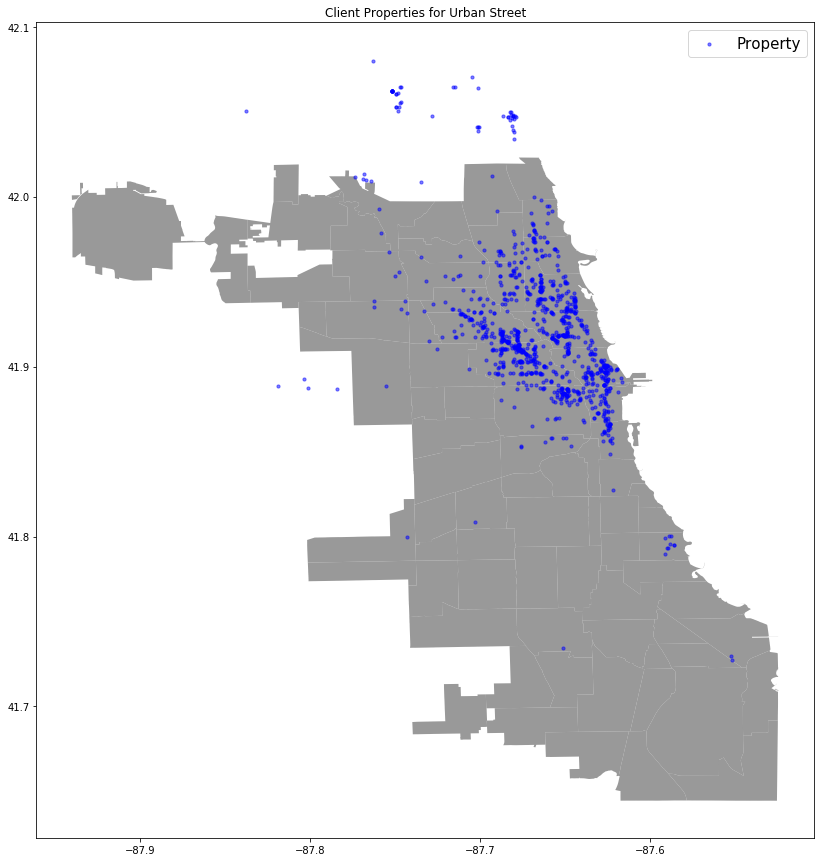

In [24]:
# Plotting map
fig, ax = plt.subplots(figsize=(15,15))
chicago_map.plot(ax=ax, alpha=0.8, color='grey')

# Plotting arrests and non-arrests on map
geo_df.plot(ax=ax, 
            markersize=10, 
            color='blue', 
            marker='o', 
            alpha=.5, 
            label='Property'
           )

plt.legend(prop={'size':15})
plt.title('Client Properties for Urban Street')
plt.show()

### 4. Invoices

Identifying:
1. Greatest revenue sources

In [25]:
invoices['Total $'] = invoices['Total $'].replace('[\$,]', '', regex=True).astype(float)
invoices['Balance $'] = invoices['Balance $'].replace('[\$,]', '', regex=True).astype(float)

In [26]:
foo = invoices.groupby('Subscription Package')['Total $'].agg(['mean','count'])
foo['return'] = foo['mean'] / foo['count']
foo

,mean,count,return
Subscription Package,,,
- Select -,105.647173,711,0.148590
CLEAN,39.230545,1339,0.029298
CLEAN +,48.641197,568,0.085636
QUARTERLY CLEAN,46.000000,8,5.750000
QUARTERLY CLEAN +,83.846154,26,3.224852
SUPER CLEAN,32.723144,916,0.035724
SUPER CLEAN +,38.191940,1557,0.024529
SUPER CLEAN ++,36.862067,179,0.205933
SUPER CLEAN ++++,59.192599,685,0.086413


### 5. Payments
Identifying:
1. Highest revenue-generating clients

In [27]:
payments['Total $'] = payments['Total $'].str.replace(',','').astype(float)

In [28]:
# Identifying biggest clients
clients = payments.groupby('Client name').sum()

# Previewing (Hiding index for anonymity)
clients.sort_values(by='Total $').head(10).style.hide_index()

Total $,Fee $,Card ending #,Invoice #,Quote #
-9356,272.53,20440,38328,0
-4310,133.09,73548,144373,0
-3246,100.76,77413,98989,0
-3080,93.52,12768,56666,0
-3036,97,140580,171108,0
-3020,91.78,22946,78013,0
-2560,81.74,92175,132620,0
-2423,78.73,28028,170978,0
-2340,77.59,111744,161655,0
-2189.6,73.64,29274,186567,0


### 5. Visits

Identifying:
1. How many clients upgraded to subscription?
2. How many clients have yet to upgrade to subscription?

In [139]:
# Separating visits into subscription or non-subscription
subscription_visits = visits[visits['Line items'].str.contains('Subscription').replace(np.nan, False)]
nonsubscription_visits = visits[~visits['Line items'].str.contains('Subscription').replace(np.nan, False)]

# Grouping subscription visits by client (some clients have same name but different addresses)
subscription_clients = subscription_visits.groupby(['Client name','Address'])\
    .sum().sort_values(by='Visit based $', ascending=False)

# Grouping non-subscription visits by client
nonsubscription_clients = nonsubscription_visits.groupby(['Client name','Address'])\
    .sum().sort_values(by='Visit based $', ascending=False)
# Removing non-subscription clients who never made a payments
nonsubscription_clients = nonsubscription_clients[nonsubscription_clients['Visit based $'] > 0]

In [140]:
print('Using visits records, there exist {} clients.'\
      .format(len(visits.groupby(['Client name','Address']))))
print('Using visits records, {} clients are/were subscription clients.'\
      .format(subscription_clients.shape[0]))
print('Using visits records, {} clients never have been subscription clients.'\
      .format(nonsubscription_clients.shape[0]))

Using visits records, there exist 715 clients.
Using visits records, 491 clients are/were subscription clients.
Using visits records, 219 clients never have been subscription clients.


In [141]:
# Purifying nonsub client list by removing upgrades
unconverted = []
for target in nonsubscription_clients.index:
    if target not in subscription_clients.index:
        unconverted.append(target)

# Creating converted sub client list by recording overlap
converted = []
for target in nonsubscription_clients.index:
    if target in subscription_clients.index:
        converted.append(target)

print('Out of {} clients who began without subscription, {} have converted!' \
      .format(len(nonsubscription_clients.index), len(converted)))
print('Out of {} clients who began without subscription, {} have yet to be converted.' \
      .format(len(nonsubscription_clients.index), len(unconverted)))

Out of 219 clients who began without subscription, 55 have converted!
Out of 219 clients who began without subscription, 164 have yet to be converted.


<a id='section-3'></a>
## III. Modeling
Are there any identifying factors of clients who have chose to upgrade?

In [142]:
# Creating target feature
subscribed = []
for entry in nonsubscription_clients.index:
    if entry in converted:
        subscribed.append(True)
    else:
        subscribed.append(False)
        
# Creating df and adding target feature
model_df = nonsubscription_clients
model_df = model_df.merge(to_extract[['City','ZIP code']], 
                          left_index=True, right_index=True)
model_df.rename(columns={'Duration':'sum_duration', 'Visit based $':'sum_spent',
                        'City':'city','ZIP code':'zip'},
               inplace=True)
model_df['converted'] = subscribed

In [ ]:
actual_clients = visits.groupby(['Client name','Address'])\
    .sum().sort_values(by='Visit based $', ascending=False)

Next steps: create your modeling dataframe from the visits dataframe that includes all potentially relevant features. Some features that have yet to be added are the target variable (subscription), city, state, zip code, type of organization (restaurant, salon, etc.), most frequent type of non-recurring cleaning, average non-recurring payment amount, first recorded transaction, and average time between transactions.

From here, you can build a model that can predict for the target variable given the number of features. The step after this would be to build a recommendation system for which clients are most likely to upgrade to subscription packages.

In [ ]:
visit_identifier = visits['Client name'] + '_' + visits['Address']
prop_identifier = properties['Name'] + '_' + properties['Street 1']

actual_properties = properties[prop_identifier.isin(visit_identifier)]

In [ ]:
visit_identifier.nunique()

In [ ]:
prop_identifier.nunique()

In [ ]:
len(actual_properties)

In [ ]:
# Recording all actual clients
list_of_clients = visits.groupby('Client name').sum().sort_values(by='Visit based $', ascending=False).index

# Removing clients without payments history
actual_properties = properties[properties['Name'].isin(list_of_clients)]

# Printing differences between all clients and actual clients
print('Summary: properties contains {} entries; actual_properties contains {} entries.'\
    .format(len(properties['Name'].isin(list_of_clients)),
           sum(properties['Name'].isin(list_of_clients))))

In [ ]:
actual_properties[actual_properties['Name'].duplicated()]

**invoices**, **one_off**, **payments**, *properties*, **recurring**, *services*, *timesheets*, **transactions**, **visits**: